In [1]:
# !pip install -U scikit-learn

In [2]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datos_2c2020_tp2.models.log.Logger as logger


# TP2 - XGBoost example

El objetivo es crear un primer modelo básico de XGBoost, sin feature engineering ni hyperparameters tunning, para poder tener un primer resultado local. Luego, realizar un primer submit en kaggle y en base a eso ir mejorando el modelo

In [3]:
train = pd.read_csv("../datasets/xgb-train.csv")
test = pd.read_csv("../datasets/xgb-test.csv")

train['Month'] = pd.to_datetime(train['Month']).dt.month
test['Month'] = pd.to_datetime(test['Month']).dt.month

In [4]:
test.head(2)

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,ASP,ASP_(converted),Month,Delivery_Year,TRF,...,Source _0,Source _1,Source _2,Source _3,Account_Type_0,Account_Type_1,Account_Type_2,Total_Amount_Currency_0,Total_Amount_Currency_1,Total_Amount_Currency_2
0,1,1,1,1,10689,0.325,0.36761,1,2019,0,...,1,0,1,1,0,0,0,0,0,1
1,1,1,1,1,10689,0.320,0.36195,1,2019,0,...,1,0,1,1,0,0,0,0,0,1


In [5]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                    colsample_bytree = 0.3,
                    learning_rate = 0.1,
                    max_depth = 8,
                    n_estimators = 160,
                    alpha = 20)

# Seteo de features


In [6]:
target = "target"
features = list(train.columns)
features.remove(target)
features.remove("created_blocknum")
features.remove("Opportunity_ID")

#VANILLA NO
features.remove("delivery_delay")
features.remove("opportunity_lifetime")
features.remove("converted_taxable_amount")
features.remove("last_modified_to_delivery")
features.remove("currency_conversion_rate")
features.remove("Occur")
features.remove("delivery_window")
features.remove("account_creation_to_created_opp")

#VANILLA SI
# features.remove('Total_Taxable_Amount')
# features.remove('ASP_(converted)')
# features.remove("ASP")
# features.remove("Total_Amount")
# features.remove("Delivery_Year")
# features.remove("Week_Day")

#CONSIDERO REMOVIBLES
features.remove("late_delivery_blocknum")
features.remove("early_delivery_blocknum")
features.remove("last_modified_blocknum")
features.remove("account_creation_blocknum") #OJO CCON HIPOTESIS DEL CLIENTE VIEEJO
print("Features totales: {}".format(len(features)))


Features totales: 111


In [7]:
X_train, y_train = train.loc[:,features],train.loc[:,target]
X_test_Opp = test.loc[:,"Opportunity_ID"]
X_test = test.loc[:,features]



In [8]:
print(X_train.shape)
print(X_test.shape)

(16947, 111)
(2551, 111)


In [9]:


xg_reg.fit(X_train,y_train)


XGBRegressor(alpha=20, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=160, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=20, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
preds = xg_reg.predict(X_test)


In [11]:
pred_df = pd.DataFrame(X_test_Opp)
pred_df["Target"] = preds
pred_df = pred_df.drop_duplicates("Opportunity_ID")
pred_df
pred_df.to_csv("../submits/xgb-reg1.csv",index=False)

#

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

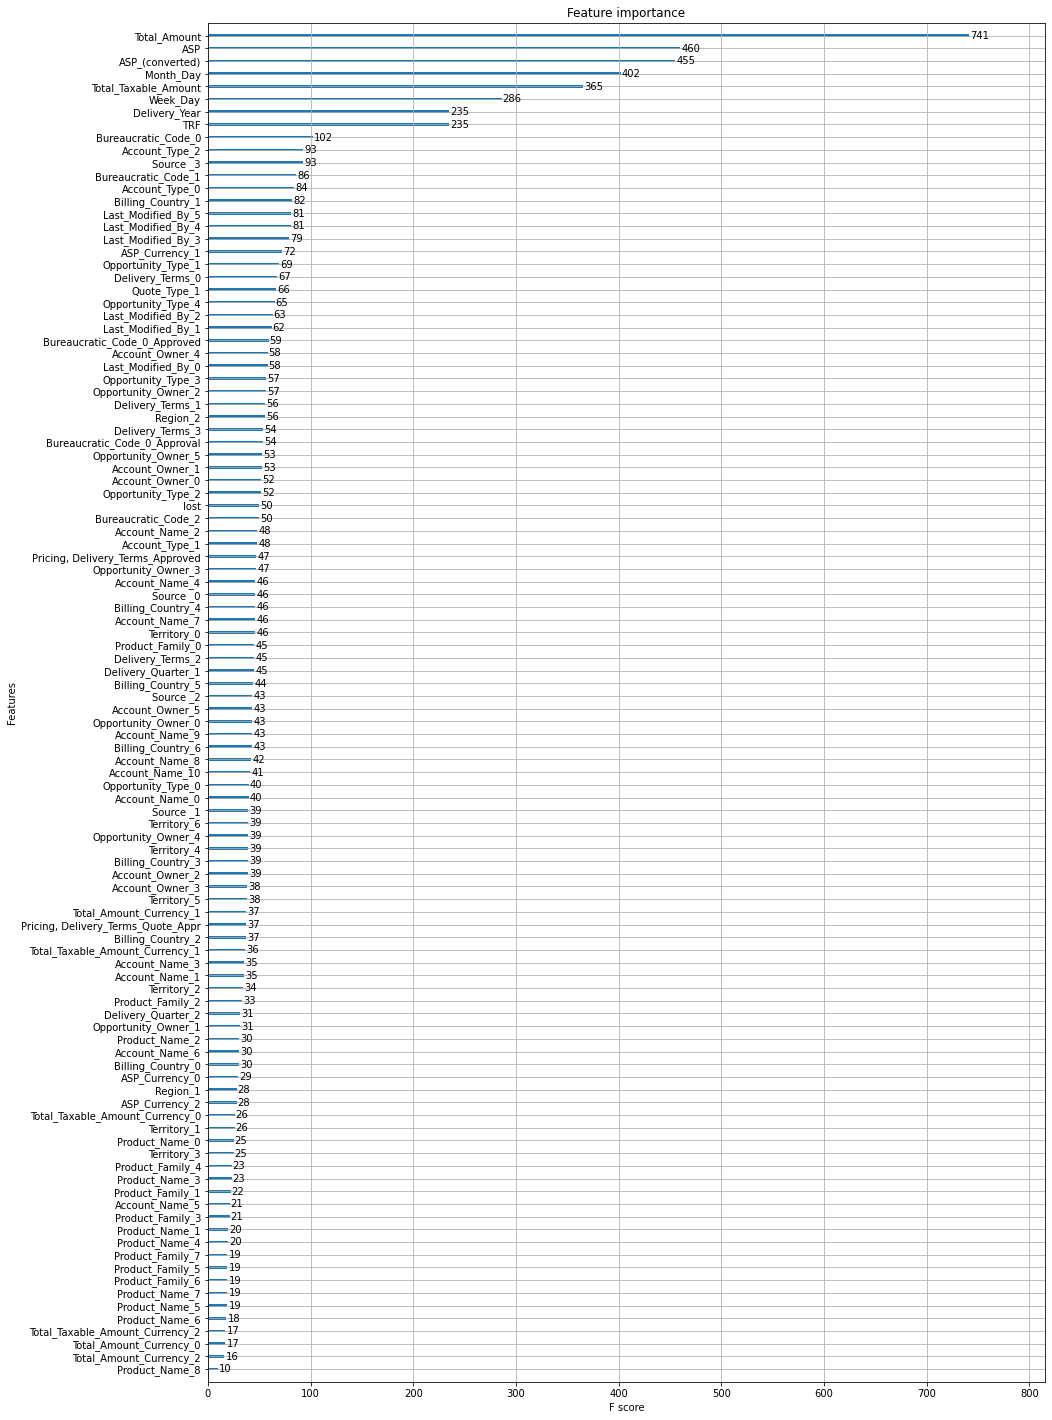

In [12]:
plt.rcParams['figure.figsize'] = [15, 25]
xgb.plot_importance(xg_reg)



In [13]:

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,
          'learning_rate': 0.1, 'max_depth': 8, 'alpha': 10,
          'eval_metric': 'logloss'}



cv_results = xgb.cv(dtrain=data_dmatrix,
                    params=params,
                    nfold=len(features),
                    num_boost_round=999,
                    early_stopping_rounds=10,
                    metrics="logloss",
                    as_pandas=True,
                    seed=151243)
cv_results.tail()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
131,0.225348,0.001648,0.282087,0.064183
132,0.224987,0.001660,0.281909,0.064188
133,0.224571,0.001632,0.279954,0.060873
134,0.224204,0.001708,0.279743,0.060796
135,0.223779,0.001710,0.279244,0.060629


In [14]:
print("Rounds    LogLoss \n  {}".format(cv_results["test-logloss-mean"].tail(1)))



Rounds    LogLoss 
  135    0.279244
Name: test-logloss-mean, dtype: float64


In [15]:
# logger.Logger.log_model("xgb", params, features, cv_score)